In [1]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from nbodykit.cosmology import Cosmology, EHPower, Planck15

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
import tools
from background import *
from tfpm import *
from tfpmfuncs import *
from fpmfuncs import *
from fpm import *
from pmconfig import Config


In [4]:
state = fastpm()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Step F 0.1000 - (0.1000) -> 0.1000 S 0.1000 P 0.1000 F 0.1000
Step K 0.1000 - (0.1000) -> 0.1803 S 0.1000 P 0.1803 F 0.1000
Step D 0.1000 - (0.1803) -> 0.3250 S 0.3250 P 0.1803 F 0.1000
Step F 0.1000 - (0.3250) -> 0.3250 S 0.3250 P 0.1803 F 0.3250
Step K 0.1803 - (0.3250) -> 0.3250 S 0.3250 P 0.3250 F 0.3250
Step K 0.3250 - (0.3250) -> 0.4228 S 0.3250 P 0.4228 F 0.3250
Step D 0.3250 - (0.4228) -> 0.5500 S 0.5500 P 0.4228 F 0.3250
Step F 0.3250 - (0.5500) -> 0.5500 S 0.5500 P 0.4228 F 0.5500
Step K 0.4228 - (0.5500) -> 0.5500 S 0.5500 P 0.5500 F 0.5500
Step K 0.5500 - (0.5500) -> 0.6529 S 0.5500 P 0.6529 F 0.5500
Step D 0.5500 - (0.6529) -> 0.7750 S 0.7750 P 0.6529 F 0.5500
Step F 0.5500 - (0.7750) -> 0.7750 S 0.7750 P 0.6529 F 0.7750
Step K 0.6529 - (0.7750) -> 0.7750 S 0.7750 P 0.7750 F 0.7750
Step K 0.7750 - (0.7750) -> 0.8803 S 0.7750 P 0.8803 F 0.7750
Step D 0.7750 - (0.8803) -> 1.0000 S 1.0000 P 0.8803 F 0.7750
Step F 0.7750 - (1.0000) -> 1.0000 S 1.0000 P 0.8803 F 1.0000
Step K 0

# Check lptz0

In [5]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32, symmetric=False)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [6]:
lptdisp = lptz0(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


In [7]:
# #
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

Tensor("zeros_like:0", shape=(8, 8, 8), dtype=float32) Tensor("Add_46:0", shape=(512, 3), dtype=float32)


In [8]:
tflptpos-lptpos

array([[ 2.9802322e-07, -5.9604645e-07, -4.7683716e-07],
       [ 3.2782555e-07,  0.0000000e+00,  0.0000000e+00],
       [ 1.1920929e-07, -8.1956387e-08,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Text(0.5,1,'Yu 2LPT')

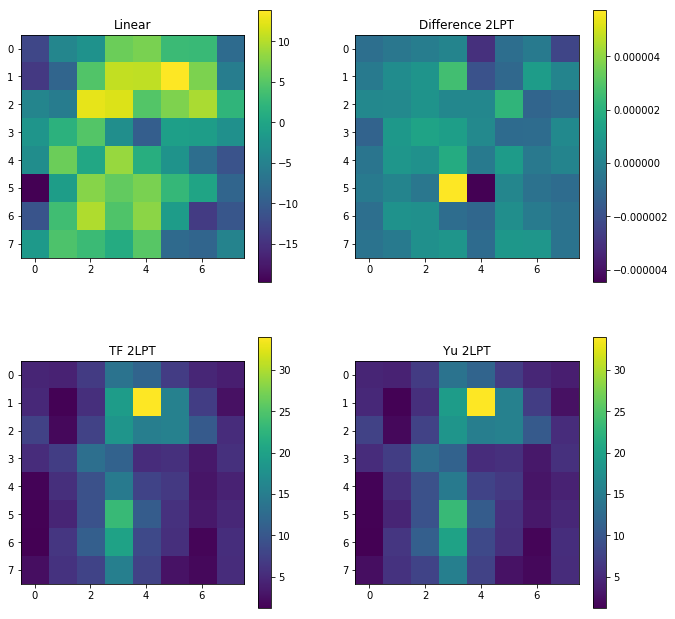

In [9]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')



#### Checkgrad

In [10]:
gindex = [0, 1, 1]
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tflptpos, tflptmesh = sess.run([grad, tlptpos, tlptmesh])

Tensor("zeros_like_3:0", shape=(8, 8, 8), dtype=float32) Tensor("Add_101:0", shape=(512, 3), dtype=float32)


In [11]:
# #
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh, tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos2, tflptmesh2 = sess.run([tlptpos, tlptmesh])

In [12]:
(tflptmesh2 - tflptmesh)[tuple(gindex)]/dx, tgrad[0][tuple(index)]

(0.005969218909740448, 0.0059663057)

# FastPM

In [13]:
a0, a1 = conf['stages'][0], conf['stages'][1]
ah = (a0*a1)**0.5

### lpt IC

In [14]:
# #
statelpt = solver.lpt(lineark, grid, a0, order=2)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatelpt = sess.run(tflptic)
# tfstatelpt = ttmp.copy()

In [15]:
(tfstatelpt[0])/ statelpt.X

array([[0.99625576, 0.9994946 , 1.0004666 ],
       [0.9967582 , 0.99955595, 1.0000006 ],
       [0.99915403, 0.99019474, 0.99999166],
       ...,
       [1.0000002 , 1.0000002 , 1.        ],
       [1.0000004 , 1.0000004 , 1.0000004 ],
       [1.0000005 , 1.0000005 , 1.0000006 ]], dtype=float32)

In [16]:
(tfstatelpt[0]-grid)/ statelpt.S

array([[0.99625576, 0.9994946 , 1.0004666 ],
       [0.9967582 , 0.99955595, 1.000004  ],
       [0.99915403, 0.99019474, 0.99986   ],
       ...,
       [1.0001172 , 1.0000492 , 1.0000007 ],
       [1.0000639 , 1.0000395 , 0.9999775 ],
       [0.9993375 , 0.9997398 , 0.9998761 ]], dtype=float32)

In [17]:
(tfstatelpt[1])/ statelpt.V, (tfstatelpt[1])/ statelpt.P

(array([[0.00099668, 0.0009995 , 0.00100045],
        [0.00099685, 0.00099957, 0.00100001],
        [0.00099915, 0.00098787, 0.00099987],
        ...,
        [0.00100013, 0.00100006, 0.001     ],
        [0.00100006, 0.00100004, 0.00099998],
        [0.00099934, 0.0009997 , 0.00099988]], dtype=float32),
 array([[0.99668276, 0.9995004 , 1.0004463 ],
        [0.9968519 , 0.999565  , 1.0000072 ],
        [0.9991539 , 0.9878713 , 0.99986607],
        ...,
        [1.0001266 , 1.0000583 , 0.9999997 ],
        [1.0000564 , 1.0000405 , 0.9999778 ],
        [0.9993389 , 0.99970114, 0.9998788 ]], dtype=float32))

In [18]:
(tfstatelpt[2])/ statelpt.F

array([[0.9971645 , 0.9995088 , 1.00042   ],
       [0.9969781 , 0.9995772 , 1.0000113 ],
       [0.9991538 , 0.9820906 , 0.9998735 ],
       ...,
       [1.000129  , 1.0000563 , 0.9999997 ],
       [1.0000545 , 1.0000383 , 0.99997747],
       [0.9993789 , 0.9996736 , 0.99988025]], dtype=float32)

#### Checkgrad

In [19]:
gindex = [1, 1]
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
grad = tf.gradients(tflptic[0][gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tlptic = sess.run([grad, tflptic])

In [20]:
gindex = [1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
grad = tf.gradients(tflptic[0][gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tlptic2 = sess.run([grad, tflptic])

In [21]:
tgrad[0][tuple(index)]

0.018136173

In [22]:
(tlptic2[0][tuple(gindex)] - tlptic[0][tuple(gindex)])/dx

0.018137693405151367

### Kick

In [23]:
### Example to play with the scatter

# npart = int(5) #no.of particles
# state = tf.zeros((3, npart, 3))
# indices = tf.constant([[0]])
# updates = tf.expand_dims(tf.constant(np.arange(npart*3).reshape(npart, 3)),axis=0)
# shape = state.shape
# #trying to update channel 0, i.e. first index of state

# print(indices)
# print(updates)
# print(shape)

# state = tf.scatter_nd(indices, updates, shape)
# print('state')
# with tf.Session() as sess:
#     print(sess.run(state[0]))

In [25]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['F'] = ah
solver.nbodystep.Kick(state, a0, ah, a1)

# tfstate = []
# X, P, F
##
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run([tf.rank(tfstate), tf.rank(tfstate.shape)]))
    tfstate = sess.run(tfkicked)

[3, 1]


In [26]:
ii = 1
tfstate[ii] / tfstatelpt[ii], 
tfstate[ii] / state.P

array([[0.99704075, 0.99950635, 1.0004271 ],
       [0.9969433 , 0.9995739 , 1.0000103 ],
       [0.9991539 , 0.98418176, 0.99987143],
       ...,
       [1.0001283 , 1.0000569 , 0.9999997 ],
       [1.0000551 , 1.0000389 , 0.9999775 ],
       [0.999368  , 0.9996818 , 0.99987984]], dtype=float32)

#### Checkgrad

In [ ]:
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfkicked = tfKick(tflptic, a0, ah, a1,  conf)
grad = tf.gradients(tfkicked[1][gindex], tlinear)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tkicked, tlptic = sess.run([grad, tfkicked, tflptic])
#     tkicked, tlptic = sess.run([tfkicked, tflptic])

In [ ]:
gindex = [1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfkicked = tfKick(tflptic, a0, ah, a1,  conf)
grad = tf.gradients(tfkicked[1][gindex], tlinear)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad2, tkicked2, tlptic2 = sess.run([grad, tfkicked, tflptic])


In [ ]:
print(tgrad[0][tuple(index)])

In [ ]:
for ii in range(3):
    print((tkicked2[ii][tuple(gindex)] - tkicked[ii][tuple(gindex)])/dx)
#     print(tkicked2[ii][tuple(gindex)])


### Drift

In [ ]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [ ]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['P'] = ah
solver.nbodystep.Drift(state, a0, ah, a1)

# #
tfkicked = tfDrift(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [ ]:
ii = 0
#tfstate[ii] / tfstatelpt[ii], 
tfstate[ii] / state.X

### Force

In [ ]:
# #
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
delk = solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfForce(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)
    
#     tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
# tfforced = tfForce(tflptic, a0, ah, a1, conf)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     ttmp0, ttmp1 = sess.run([tfforced, tflptic])

In [ ]:
statelpt.F/tfstatelpt[2]

In [ ]:
ii = 2
tfstate[2] / state.F

# Put it all together

In [27]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
# kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
# gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32, symmetric=False)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: mode argument is deprecated, use type


In [36]:
# %%timeit 
lineark = linear.r2c()
state = solver.lpt(lineark, grid, a0, order=2)
solver.nbody(state, leapfrog(conf['stages']))
meshpm = pm.paint(state.X)

In [30]:
# %%timeit -n 3

tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstate[0], nc/bs), weight=tf.ones(nc**3))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm , tfstatepm = sess.run([tfmesh, tfstate])


1.61 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [35]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm , tfstatepm = sess.run([tfmesh, tfstate])


In [32]:
# tfmesh = tf.zeros((nc, nc, nc))
# tfmesh = cic_paint(tfmesh, tf.multiply(tfstatepm[0], nc/bs), weight=tf.ones(nc**3))

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     tfmeshpm = sess.run(tfmesh)

# meshpm = pm.paint(state.X)

Text(0.5,1,'Difference')

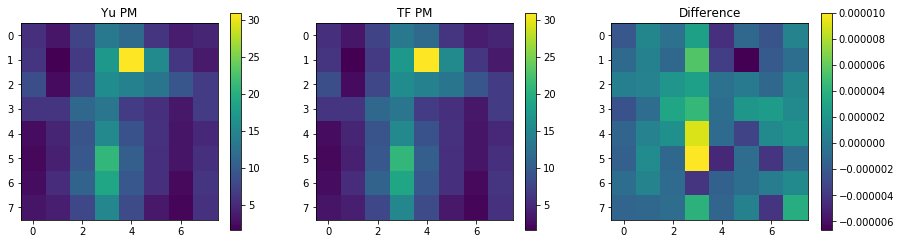

In [37]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Yu PM')
im = ax[1].imshow(tfmeshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('TF PM')
im = ax[2].imshow((meshpm-tfmeshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')


### Checkgrad

In [43]:
tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstate[0], nc/bs), weight=tf.ones(nc**3))
grad = tf.gradients(tfmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tfmeshpm , tfstatepm = sess.run([grad, tfmesh, tfstate])


In [53]:
gindex = [1, 1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstate[0], nc/bs), weight=tf.ones(nc**3))
grad = tf.gradients(tfmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm2 , tfstatepm2 = sess.run([tfmesh, tfstate])
    

In [54]:
print(tgrad[0][tuple(index)])

0.03802526


In [55]:
(tfmeshpm2[tuple(gindex)] - tfmeshpm[tuple(gindex)])/dx

0.03803670406341553

# Reconstruction